In [1]:
import os
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from PIL import Image

from read_data import read_csv, clean_data, read_stopwords_v2, split_text, read_csv_dir


## 定义文件名

In [23]:
# 由于数据爬取过程坎坷，最后有可能是一个csv文件，有可能是多个csv文件
# 这里统一下操作 我在output_final 文件夹下面新建了 input_dir 文件夹
# 数据爬取完毕后，清空input_dir下的残留文件，将当次产生的所有csv文件放入input_dir
# 并为当次的文件取一个output_name的名字，例如 chinese people_2020-12-31_2021-01-02


################# 看这里！！！！！ 一定要改！！！！！！##########################################
#################################################################################################
output_name = 'the belt and road initiative_2021_01_01_2023_06_30' # 自己取一个，契合当次任务即可，格式最好类似#
#################################################################################################


prefix_path = output_name
data_path = output_name + '.csv'
root_dir = os.path.join('output_final', prefix_path)
input_dir = os.path.join('output_final', 'input_dir')
if not os.path.exists(root_dir):
    os.mkdir(root_dir)
else:
    print('文件夹已存在，如果要覆盖先删除重新创建，不覆盖原文件，断点重启可忽略')

## 数据整合

In [24]:
df = read_csv_dir(input_dir)
# 去重代码，需要取消注释，不需要注释掉
df = df.drop_duplicates() 
df.to_csv(os.path.join(root_dir, data_path), index=False, encoding='utf_8_sig')

## 数据清洗

In [25]:
df = read_csv(os.path.join(root_dir, data_path))
df['clean_data'] = df['Embedded_text'].apply(clean_data)
df['tokens'] = df['clean_data'].apply(split_text, args=(read_stopwords_v2(), ))
df.to_csv(os.path.join(root_dir, prefix_path + '_res.csv'), index=False, encoding='utf_8_sig')  # 该行保存文件，后缀对应相关功能

## 情感分析

In [26]:
tokenizer = AutoTokenizer.from_pretrained('data/sentiment_model/')
model = AutoModelForSequenceClassification.from_pretrained('data/sentiment_model/')


def predict(text):
    token = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        output = model(**token).logits
    return output.argmax().item() - 1


contents = df['clean_data'].tolist()
labels = []
for i in tqdm(contents):
    labels.append(predict(str(i)))
df['sentiment'] = labels

df.to_csv(os.path.join(root_dir, prefix_path + '_res_sentiment.csv'), index=False, encoding='utf_8_sig')  # 该行保存文件，后缀对应相关功能

## 分情感的LDA主题分析

In [27]:
df = pd.read_csv(os.path.join(root_dir, prefix_path + '_res_sentiment.csv'))


neg_df = df[df['sentiment'] == -1]
neu_df = df[df['sentiment'] == 0]
pos_df = df[df['sentiment'] == 1]

def topic_analysis(df, n_components, top_n):
    contents = [' '.join(eval(i)) for i in df['tokens'].to_list()]
    tfidf = TfidfVectorizer(ngram_range=(1, 1))
    x = tfidf.fit_transform(contents)
    model = LatentDirichletAllocation(n_components=n_components, random_state=42)
    model.fit(x)
    featute_names = tfidf.get_feature_names()
    rows = []
    for topic in model.components_:
        topwords = [featute_names[i] for i in topic.argsort()[: -top_n - 1:-1]]
        rows.append(topwords)
    return rows

def show_rows(rows):
    for idx, row in enumerate(rows):
        print(f'topic :{idx + 1}')
        print(row)

print('total: ')
total_rows = topic_analysis(df, 10, 10)
show_rows(total_rows)
print('=' * 100)
print('positive: ')
rows = topic_analysis(pos_df, 10, 10)
show_rows(rows)
print('-' * 100)
print('neutrality: ')
rows = topic_analysis(neu_df, 10, 10)
show_rows(rows)
print('-' * 100)
print('negtive: ')
rows = topic_analysis(neg_df, 10, 10)
show_rows(rows)
print('-' * 100)


# 如果她对主题词不满意，希望某些词不要出现作为主题词，比如chinese，在每个主题下都出现，她想筛选掉，
# 就在data/stopwords.txt 文件的最后一行加上chinese，那么chinese会被过滤，不会出现作为主题词

# 主题分析使用函数 topic_analysis(df, n_components, top_n)
# df 是数据，n_components是主题数，top_n是每个主题展示多少词#
# 例如 topic_analysis(pos_df, 10, 10)
# 代表乐观数据中，分10个主题，每个主题展示10个词，可根据需要进行更改


total: 
topic :1
['road', 'belt', 'initiative', 'china', 'countries', 'bri', 'replying', 'economic', 'cooperation', 'infrastructure']
topic :2
['replying', 'road', 'initiative', 'belt', 'china', 'part', 'chinese', 'silk', 'states', 'beneficial']
topic :3
['replying', 'road', 'initiative', 'belt', 'china', 'reuters', 'via', 'potus', 'plus', 'benjaminnorton']
topic :4
['road', 'belt', 'initiative', 'replying', 'china', 'signed', 'memorandum', 'bri', 'chinese', 'understanding']
topic :5
['replying', 'road', 'belt', 'initiative', 'china', 'youtube', 'danielandrewsmp', 'edourdooo', 'sabotage', 'chinese']
topic :6
['replying', 'road', 'belt', 'initiative', 'china', 'zerohedge', 'chinese', 'disclosetv', 'dispute', 'research']
topic :7
['road', 'belt', 'initiative', 'replying', 'china', 'us', 'countries', 'afghanistan', 'chinese', 'bri']
topic :8
['others', 'replying', 'road', 'belt', 'initiative', 'china', 'cchukudebelu', 'shows', 'shiwei', 'shen']
topic :9
['replying', 'road', 'belt', 'initi

## 情感分析的结果保存，相关后缀是不同的情绪

In [28]:
neg_df.to_excel(os.path.join(root_dir, prefix_path + '_res_sentiment_neg.xlsx'), index=False, engine='xlsxwriter')  # 该行保存文件，后缀对应相关功能
neu_df.to_excel(os.path.join(root_dir, prefix_path + '_res_sentiment_neu.xlsx'), index=False, engine='xlsxwriter')  # 该行保存文件，后缀对应相关功能
pos_df.to_excel(os.path.join(root_dir, prefix_path + '_res_sentiment_pos.xlsx'), index=False, engine='xlsxwriter')  # 该行保存文件，后缀对应相关功能

## 词频统计

In [29]:
words = []
for i in df['tokens']:
    words.extend(eval(i))
    
words_dic = Counter(words)
words = pd.DataFrame(words_dic.items(), columns=['word', 'count'])
words.to_excel(os.path.join(root_dir, prefix_path + '_word_count.xlsx'), index=False)  # 该行保存文件，后缀对应相关功能

## 主题词占比

In [30]:
# TODO 未完成

df = pd.read_csv(os.path.join(root_dir, prefix_path + '_res_sentiment.csv'))
tokens = df['tokens'].apply(eval)

def cal_probability(token, topics):
    inter = set(token).intersection(set(topics))
    return int(len(token) > 0)


## 词云图

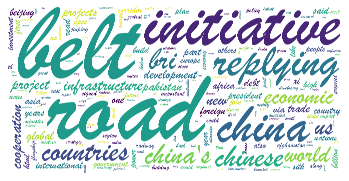

In [31]:
res_dic = words_dic
wd = WordCloud(font_path='C:\Windows\Fonts\STXINGKA.TTF', background_color='white', scale=60)
wd.generate_from_frequencies(res_dic)
plt.imshow(wd)
plt.axis('off')
plt.savefig(os.path.join(root_dir, prefix_path + '_word_cloud.png'), dpi=300, bbox_inches='tight')  # 该行保存文件，后缀对应相关功能
plt.show()

# 生成清晰图云比较慢，多等会儿

## 分情感统计词频

In [32]:
def seg_word_count(seg_name):
    df = pd.read_excel(os.path.join(root_dir, prefix_path + '_res_sentiment_{}.xlsx'.format(seg_name)))
    words = []
    for i in df['tokens']:
        words.extend(eval(i))

    words_dic = Counter(words)
    words = pd.DataFrame(words_dic.items(), columns=['word', 'count'])
    words.to_excel(os.path.join(root_dir, prefix_path + '_word_count_{}.xlsx'.format(seg_name)), index=False)

seg_word_count('pos')
seg_word_count('neg')
seg_word_count('neu')